In [1]:
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torchvision.utils as vutils

import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=30, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=1000, help="number of image channels")
parser.add_argument('-f')
opt = parser.parse_args()

In [3]:
cuda = True if torch.cuda.is_available() else False
print(cuda)

G_Loss = []
D_Loss = []

True


In [4]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        # print(out)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()

#         def discriminator_block(in_filters, out_filters, bn=True):
#             block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
#             if bn:
#                 block.append(nn.BatchNorm2d(out_filters, 0.8))
#             return block

#         self.model = nn.Sequential(
#             *discriminator_block(opt.channels, 16, bn=False),
#             *discriminator_block(16, 32),
#             *discriminator_block(32, 64),
#             *discriminator_block(64, 128),
#         )

#         # The height and width of downsampled image
#         ds_size = opt.img_size // 2 ** 4
#         self.adv_layer = nn.Linear(128 * ds_size ** 2, 1)

#     def forward(self, img):
#         out = self.model(img)
#         out = out.view(out.shape[0], -1)
#         validity = self.adv_layer(out)

#         return validity

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #nn.Flatten(),
            #nn.Linear(img_rows*img_cols*channels,128),
            #nn.LeakyReLU(),
            #nn.Linear(128,1),
            #nn.Sigmoid(),
            nn.Flatten(),
            nn.Linear(28*28*1,7*7*8),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Dropout(0.3),
            nn.Linear(7*7*8,7*7*4),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Dropout(0.3),
            nn.Linear(7*7*4,7*7*2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Dropout(0.3),
            nn.Linear(7*7*2,7*7),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Dropout(0.3),
            nn.Linear(7*7,1)
        )
    def forward(self,x):
        #inp = x.view(x.shape[0],img_rows*img_cols*channels)
        validity = self.model(x)
        return validity
generator = Generator()
discriminator = Discriminator()

In [13]:
# !!! Minimizes MSE instead of BCE
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True, drop_last = True
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

[Epoch 0/30] [Batch 0/468] [D loss: 0.216034] [G loss: 0.316126]


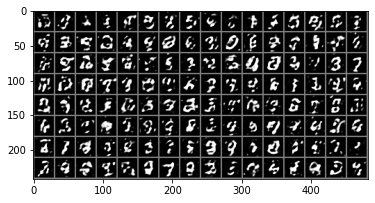

[Epoch 0/30] [Batch 1/468] [D loss: 0.348005] [G loss: 0.959890]
[Epoch 0/30] [Batch 2/468] [D loss: 0.211725] [G loss: 0.387629]
[Epoch 0/30] [Batch 3/468] [D loss: 0.254072] [G loss: 0.250236]
[Epoch 0/30] [Batch 4/468] [D loss: 0.218830] [G loss: 0.476155]
[Epoch 0/30] [Batch 5/468] [D loss: 0.250428] [G loss: 0.395344]
[Epoch 0/30] [Batch 6/468] [D loss: 0.260022] [G loss: 0.298233]
[Epoch 0/30] [Batch 7/468] [D loss: 0.246578] [G loss: 0.397944]
[Epoch 0/30] [Batch 8/468] [D loss: 0.248793] [G loss: 0.335171]
[Epoch 0/30] [Batch 9/468] [D loss: 0.266763] [G loss: 0.262792]
[Epoch 0/30] [Batch 10/468] [D loss: 0.257196] [G loss: 0.368212]
[Epoch 0/30] [Batch 11/468] [D loss: 0.267158] [G loss: 0.313314]
[Epoch 0/30] [Batch 12/468] [D loss: 0.271483] [G loss: 0.282591]
[Epoch 0/30] [Batch 13/468] [D loss: 0.281427] [G loss: 0.266197]
[Epoch 0/30] [Batch 14/468] [D loss: 0.283524] [G loss: 0.321886]
[Epoch 0/30] [Batch 15/468] [D loss: 0.273370] [G loss: 0.325956]
[Epoch 0/30] [Batch

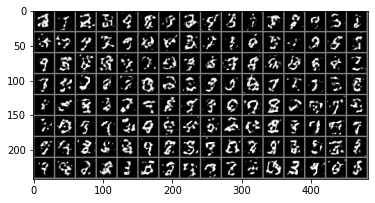

[Epoch 2/30] [Batch 65/468] [D loss: 0.037146] [G loss: 0.444856]
[Epoch 2/30] [Batch 66/468] [D loss: 0.029568] [G loss: 0.444856]
[Epoch 2/30] [Batch 67/468] [D loss: 0.030881] [G loss: 0.444856]
[Epoch 2/30] [Batch 68/468] [D loss: 0.041333] [G loss: 0.444856]
[Epoch 2/30] [Batch 69/468] [D loss: 0.031515] [G loss: 0.444856]
[Epoch 2/30] [Batch 70/468] [D loss: 0.034837] [G loss: 0.444856]
[Epoch 2/30] [Batch 71/468] [D loss: 0.031041] [G loss: 0.444856]
[Epoch 2/30] [Batch 72/468] [D loss: 0.028819] [G loss: 0.444856]
[Epoch 2/30] [Batch 73/468] [D loss: 0.026718] [G loss: 0.444856]
[Epoch 2/30] [Batch 74/468] [D loss: 0.029083] [G loss: 0.444856]
[Epoch 2/30] [Batch 75/468] [D loss: 0.034928] [G loss: 0.444856]
[Epoch 2/30] [Batch 76/468] [D loss: 0.030286] [G loss: 0.444856]
[Epoch 2/30] [Batch 77/468] [D loss: 0.030964] [G loss: 0.444856]
[Epoch 2/30] [Batch 78/468] [D loss: 0.029849] [G loss: 0.444856]
[Epoch 2/30] [Batch 79/468] [D loss: 0.030042] [G loss: 0.444856]
[Epoch 2/3

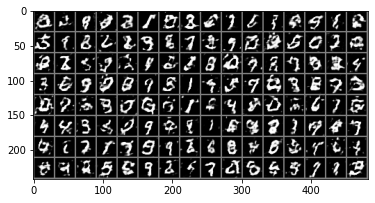

[Epoch 4/30] [Batch 129/468] [D loss: 0.058532] [G loss: 0.386779]
[Epoch 4/30] [Batch 130/468] [D loss: 0.067471] [G loss: 0.386779]
[Epoch 4/30] [Batch 131/468] [D loss: 0.052087] [G loss: 0.386779]
[Epoch 4/30] [Batch 132/468] [D loss: 0.053863] [G loss: 0.386779]
[Epoch 4/30] [Batch 133/468] [D loss: 0.060389] [G loss: 0.386779]
[Epoch 4/30] [Batch 134/468] [D loss: 0.050753] [G loss: 0.386779]
[Epoch 4/30] [Batch 135/468] [D loss: 0.054801] [G loss: 0.386779]
[Epoch 4/30] [Batch 136/468] [D loss: 0.057201] [G loss: 0.386779]
[Epoch 4/30] [Batch 137/468] [D loss: 0.058882] [G loss: 0.386779]
[Epoch 4/30] [Batch 138/468] [D loss: 0.059923] [G loss: 0.386779]
[Epoch 4/30] [Batch 139/468] [D loss: 0.053729] [G loss: 0.386779]
[Epoch 4/30] [Batch 140/468] [D loss: 0.047592] [G loss: 0.386779]
[Epoch 4/30] [Batch 141/468] [D loss: 0.053684] [G loss: 0.386779]
[Epoch 4/30] [Batch 142/468] [D loss: 0.058033] [G loss: 0.386779]
[Epoch 4/30] [Batch 143/468] [D loss: 0.051065] [G loss: 0.386

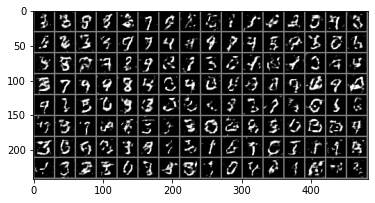

[Epoch 6/30] [Batch 193/468] [D loss: 0.167026] [G loss: 0.417489]
[Epoch 6/30] [Batch 194/468] [D loss: 0.173153] [G loss: 0.432304]
[Epoch 6/30] [Batch 195/468] [D loss: 0.201317] [G loss: 0.470157]
[Epoch 6/30] [Batch 196/468] [D loss: 0.198516] [G loss: 0.286533]
[Epoch 6/30] [Batch 197/468] [D loss: 0.218689] [G loss: 0.429345]
[Epoch 6/30] [Batch 198/468] [D loss: 0.192167] [G loss: 0.479650]
[Epoch 6/30] [Batch 199/468] [D loss: 0.215067] [G loss: 0.331811]
[Epoch 6/30] [Batch 200/468] [D loss: 0.221251] [G loss: 0.348871]
[Epoch 6/30] [Batch 201/468] [D loss: 0.213526] [G loss: 0.458076]
[Epoch 6/30] [Batch 202/468] [D loss: 0.199546] [G loss: 0.356112]
[Epoch 6/30] [Batch 203/468] [D loss: 0.195899] [G loss: 0.416652]
[Epoch 6/30] [Batch 204/468] [D loss: 0.224304] [G loss: 0.401246]
[Epoch 6/30] [Batch 205/468] [D loss: 0.176285] [G loss: 0.413787]
[Epoch 6/30] [Batch 206/468] [D loss: 0.200303] [G loss: 0.405359]
[Epoch 6/30] [Batch 207/468] [D loss: 0.186118] [G loss: 0.318

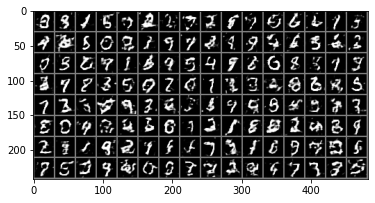

[Epoch 8/30] [Batch 257/468] [D loss: 0.026142] [G loss: 0.427107]
[Epoch 8/30] [Batch 258/468] [D loss: 0.032913] [G loss: 0.427107]
[Epoch 8/30] [Batch 259/468] [D loss: 0.040276] [G loss: 0.427107]
[Epoch 8/30] [Batch 260/468] [D loss: 0.020834] [G loss: 0.427107]
[Epoch 8/30] [Batch 261/468] [D loss: 0.015817] [G loss: 0.427107]
[Epoch 8/30] [Batch 262/468] [D loss: 0.017342] [G loss: 0.427107]
[Epoch 8/30] [Batch 263/468] [D loss: 0.021282] [G loss: 0.427107]
[Epoch 8/30] [Batch 264/468] [D loss: 0.015601] [G loss: 0.427107]
[Epoch 8/30] [Batch 265/468] [D loss: 0.017578] [G loss: 0.427107]
[Epoch 8/30] [Batch 266/468] [D loss: 0.018034] [G loss: 0.427107]
[Epoch 8/30] [Batch 267/468] [D loss: 0.022227] [G loss: 0.427107]
[Epoch 8/30] [Batch 268/468] [D loss: 0.017783] [G loss: 0.427107]
[Epoch 8/30] [Batch 269/468] [D loss: 0.019804] [G loss: 0.427107]
[Epoch 8/30] [Batch 270/468] [D loss: 0.017807] [G loss: 0.427107]
[Epoch 8/30] [Batch 271/468] [D loss: 0.015785] [G loss: 0.427

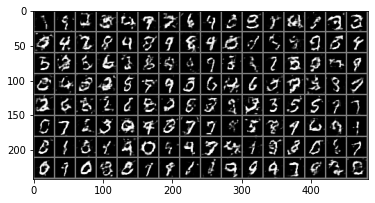

[Epoch 10/30] [Batch 321/468] [D loss: 0.033362] [G loss: 0.438271]
[Epoch 10/30] [Batch 322/468] [D loss: 0.025277] [G loss: 0.438271]
[Epoch 10/30] [Batch 323/468] [D loss: 0.032552] [G loss: 0.438271]
[Epoch 10/30] [Batch 324/468] [D loss: 0.027488] [G loss: 0.438271]
[Epoch 10/30] [Batch 325/468] [D loss: 0.027528] [G loss: 0.438271]
[Epoch 10/30] [Batch 326/468] [D loss: 0.031638] [G loss: 0.438271]
[Epoch 10/30] [Batch 327/468] [D loss: 0.031189] [G loss: 0.438271]
[Epoch 10/30] [Batch 328/468] [D loss: 0.030409] [G loss: 0.438271]
[Epoch 10/30] [Batch 329/468] [D loss: 0.032002] [G loss: 0.438271]
[Epoch 10/30] [Batch 330/468] [D loss: 0.030972] [G loss: 0.438271]
[Epoch 10/30] [Batch 331/468] [D loss: 0.036803] [G loss: 0.438271]
[Epoch 10/30] [Batch 332/468] [D loss: 0.028666] [G loss: 0.438271]
[Epoch 10/30] [Batch 333/468] [D loss: 0.026198] [G loss: 0.438271]
[Epoch 10/30] [Batch 334/468] [D loss: 0.024637] [G loss: 0.438271]
[Epoch 10/30] [Batch 335/468] [D loss: 0.028472]

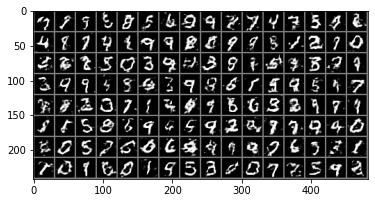

[Epoch 12/30] [Batch 385/468] [D loss: 0.199968] [G loss: 0.435179]
[Epoch 12/30] [Batch 386/468] [D loss: 0.185894] [G loss: 0.434187]
[Epoch 12/30] [Batch 387/468] [D loss: 0.214759] [G loss: 0.337568]
[Epoch 12/30] [Batch 388/468] [D loss: 0.180217] [G loss: 0.389408]
[Epoch 12/30] [Batch 389/468] [D loss: 0.202836] [G loss: 0.402372]
[Epoch 12/30] [Batch 390/468] [D loss: 0.209250] [G loss: 0.333219]
[Epoch 12/30] [Batch 391/468] [D loss: 0.182978] [G loss: 0.395840]
[Epoch 12/30] [Batch 392/468] [D loss: 0.207184] [G loss: 0.458210]
[Epoch 12/30] [Batch 393/468] [D loss: 0.193654] [G loss: 0.376787]
[Epoch 12/30] [Batch 394/468] [D loss: 0.226544] [G loss: 0.274520]
[Epoch 12/30] [Batch 395/468] [D loss: 0.225808] [G loss: 0.510238]
[Epoch 12/30] [Batch 396/468] [D loss: 0.211392] [G loss: 0.416371]
[Epoch 12/30] [Batch 397/468] [D loss: 0.212638] [G loss: 0.296013]
[Epoch 12/30] [Batch 398/468] [D loss: 0.193311] [G loss: 0.423107]
[Epoch 12/30] [Batch 399/468] [D loss: 0.204714]

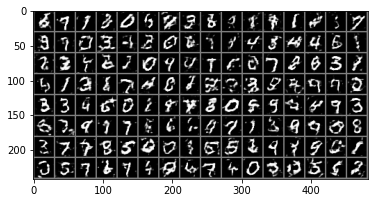

[Epoch 14/30] [Batch 449/468] [D loss: 0.015668] [G loss: 0.420472]
[Epoch 14/30] [Batch 450/468] [D loss: 0.016935] [G loss: 0.420472]
[Epoch 14/30] [Batch 451/468] [D loss: 0.013592] [G loss: 0.420472]
[Epoch 14/30] [Batch 452/468] [D loss: 0.012902] [G loss: 0.420472]
[Epoch 14/30] [Batch 453/468] [D loss: 0.010578] [G loss: 0.420472]
[Epoch 14/30] [Batch 454/468] [D loss: 0.012918] [G loss: 0.420472]
[Epoch 14/30] [Batch 455/468] [D loss: 0.015299] [G loss: 0.420472]
[Epoch 14/30] [Batch 456/468] [D loss: 0.012758] [G loss: 0.420472]
[Epoch 14/30] [Batch 457/468] [D loss: 0.018084] [G loss: 0.420472]
[Epoch 14/30] [Batch 458/468] [D loss: 0.016839] [G loss: 0.420472]
[Epoch 14/30] [Batch 459/468] [D loss: 0.015491] [G loss: 0.420472]
[Epoch 14/30] [Batch 460/468] [D loss: 0.013965] [G loss: 0.420472]
[Epoch 14/30] [Batch 461/468] [D loss: 0.011417] [G loss: 0.420472]
[Epoch 14/30] [Batch 462/468] [D loss: 0.012462] [G loss: 0.420472]
[Epoch 14/30] [Batch 463/468] [D loss: 0.017191]

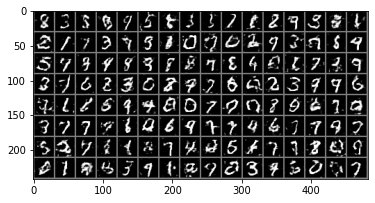

[Epoch 17/30] [Batch 45/468] [D loss: 0.014217] [G loss: 0.399802]
[Epoch 17/30] [Batch 46/468] [D loss: 0.019833] [G loss: 0.399802]
[Epoch 17/30] [Batch 47/468] [D loss: 0.025340] [G loss: 0.399802]
[Epoch 17/30] [Batch 48/468] [D loss: 0.023323] [G loss: 0.399802]
[Epoch 17/30] [Batch 49/468] [D loss: 0.017111] [G loss: 0.399802]
[Epoch 17/30] [Batch 50/468] [D loss: 0.015849] [G loss: 0.399802]
[Epoch 17/30] [Batch 51/468] [D loss: 0.017041] [G loss: 0.399802]
[Epoch 17/30] [Batch 52/468] [D loss: 0.018014] [G loss: 0.399802]
[Epoch 17/30] [Batch 53/468] [D loss: 0.021155] [G loss: 0.399802]
[Epoch 17/30] [Batch 54/468] [D loss: 0.018430] [G loss: 0.399802]
[Epoch 17/30] [Batch 55/468] [D loss: 0.018796] [G loss: 0.399802]
[Epoch 17/30] [Batch 56/468] [D loss: 0.013883] [G loss: 0.399802]
[Epoch 17/30] [Batch 57/468] [D loss: 0.019458] [G loss: 0.399802]
[Epoch 17/30] [Batch 58/468] [D loss: 0.015836] [G loss: 0.399802]
[Epoch 17/30] [Batch 59/468] [D loss: 0.016270] [G loss: 0.399

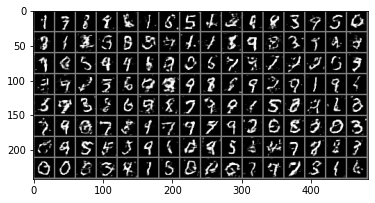

[Epoch 19/30] [Batch 109/468] [D loss: 0.058087] [G loss: 0.381705]
[Epoch 19/30] [Batch 110/468] [D loss: 0.056464] [G loss: 0.381705]
[Epoch 19/30] [Batch 111/468] [D loss: 0.085215] [G loss: 0.381705]
[Epoch 19/30] [Batch 112/468] [D loss: 0.073827] [G loss: 0.381705]
[Epoch 19/30] [Batch 113/468] [D loss: 0.060526] [G loss: 0.381705]
[Epoch 19/30] [Batch 114/468] [D loss: 0.066451] [G loss: 0.381705]
[Epoch 19/30] [Batch 115/468] [D loss: 0.101766] [G loss: 0.381705]
[Epoch 19/30] [Batch 116/468] [D loss: 0.157985] [G loss: 0.381705]
[Epoch 19/30] [Batch 117/468] [D loss: 0.108296] [G loss: 0.381705]
[Epoch 19/30] [Batch 118/468] [D loss: 0.073714] [G loss: 0.381705]
[Epoch 19/30] [Batch 119/468] [D loss: 0.085608] [G loss: 0.381705]
[Epoch 19/30] [Batch 120/468] [D loss: 0.066458] [G loss: 0.381705]
[Epoch 19/30] [Batch 121/468] [D loss: 0.045150] [G loss: 0.381705]
[Epoch 19/30] [Batch 122/468] [D loss: 0.071797] [G loss: 0.381705]
[Epoch 19/30] [Batch 123/468] [D loss: 0.043387]

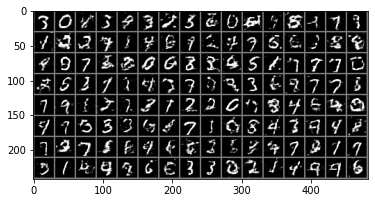

[Epoch 21/30] [Batch 173/468] [D loss: 0.221412] [G loss: 0.397058]
[Epoch 21/30] [Batch 174/468] [D loss: 0.226507] [G loss: 0.290661]
[Epoch 21/30] [Batch 175/468] [D loss: 0.211159] [G loss: 0.305834]
[Epoch 21/30] [Batch 176/468] [D loss: 0.216179] [G loss: 0.357234]
[Epoch 21/30] [Batch 177/468] [D loss: 0.213028] [G loss: 0.339697]
[Epoch 21/30] [Batch 178/468] [D loss: 0.221092] [G loss: 0.326566]
[Epoch 21/30] [Batch 179/468] [D loss: 0.232273] [G loss: 0.320041]
[Epoch 21/30] [Batch 180/468] [D loss: 0.222934] [G loss: 0.384550]
[Epoch 21/30] [Batch 181/468] [D loss: 0.221564] [G loss: 0.335877]
[Epoch 21/30] [Batch 182/468] [D loss: 0.215808] [G loss: 0.327381]
[Epoch 21/30] [Batch 183/468] [D loss: 0.224268] [G loss: 0.361717]
[Epoch 21/30] [Batch 184/468] [D loss: 0.239964] [G loss: 0.378395]
[Epoch 21/30] [Batch 185/468] [D loss: 0.211890] [G loss: 0.351065]
[Epoch 21/30] [Batch 186/468] [D loss: 0.223281] [G loss: 0.333759]
[Epoch 21/30] [Batch 187/468] [D loss: 0.219857]

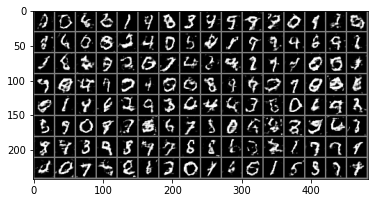

[Epoch 23/30] [Batch 237/468] [D loss: 0.012034] [G loss: 0.376494]
[Epoch 23/30] [Batch 238/468] [D loss: 0.020208] [G loss: 0.376494]
[Epoch 23/30] [Batch 239/468] [D loss: 0.016023] [G loss: 0.376494]
[Epoch 23/30] [Batch 240/468] [D loss: 0.015208] [G loss: 0.376494]
[Epoch 23/30] [Batch 241/468] [D loss: 0.013845] [G loss: 0.376494]
[Epoch 23/30] [Batch 242/468] [D loss: 0.016103] [G loss: 0.376494]
[Epoch 23/30] [Batch 243/468] [D loss: 0.011441] [G loss: 0.376494]
[Epoch 23/30] [Batch 244/468] [D loss: 0.015351] [G loss: 0.376494]
[Epoch 23/30] [Batch 245/468] [D loss: 0.018141] [G loss: 0.376494]
[Epoch 23/30] [Batch 246/468] [D loss: 0.016992] [G loss: 0.376494]
[Epoch 23/30] [Batch 247/468] [D loss: 0.011091] [G loss: 0.376494]
[Epoch 23/30] [Batch 248/468] [D loss: 0.019157] [G loss: 0.376494]
[Epoch 23/30] [Batch 249/468] [D loss: 0.016301] [G loss: 0.376494]
[Epoch 23/30] [Batch 250/468] [D loss: 0.017947] [G loss: 0.376494]
[Epoch 23/30] [Batch 251/468] [D loss: 0.012055]

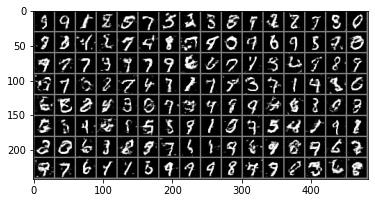

[Epoch 25/30] [Batch 301/468] [D loss: 0.028863] [G loss: 0.324424]
[Epoch 25/30] [Batch 302/468] [D loss: 0.021805] [G loss: 0.324424]
[Epoch 25/30] [Batch 303/468] [D loss: 0.024596] [G loss: 0.324424]
[Epoch 25/30] [Batch 304/468] [D loss: 0.026335] [G loss: 0.324424]
[Epoch 25/30] [Batch 305/468] [D loss: 0.025644] [G loss: 0.324424]
[Epoch 25/30] [Batch 306/468] [D loss: 0.028660] [G loss: 0.324424]
[Epoch 25/30] [Batch 307/468] [D loss: 0.020835] [G loss: 0.324424]
[Epoch 25/30] [Batch 308/468] [D loss: 0.029733] [G loss: 0.324424]
[Epoch 25/30] [Batch 309/468] [D loss: 0.026964] [G loss: 0.324424]
[Epoch 25/30] [Batch 310/468] [D loss: 0.028835] [G loss: 0.324424]
[Epoch 25/30] [Batch 311/468] [D loss: 0.026886] [G loss: 0.324424]
[Epoch 25/30] [Batch 312/468] [D loss: 0.031226] [G loss: 0.324424]
[Epoch 25/30] [Batch 313/468] [D loss: 0.022764] [G loss: 0.324424]
[Epoch 25/30] [Batch 314/468] [D loss: 0.030296] [G loss: 0.324424]
[Epoch 25/30] [Batch 315/468] [D loss: 0.025552]

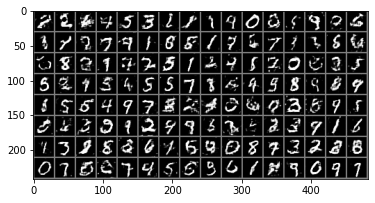

[Epoch 27/30] [Batch 365/468] [D loss: 0.222597] [G loss: 0.303960]
[Epoch 27/30] [Batch 366/468] [D loss: 0.232187] [G loss: 0.313235]
[Epoch 27/30] [Batch 367/468] [D loss: 0.205297] [G loss: 0.392556]
[Epoch 27/30] [Batch 368/468] [D loss: 0.207101] [G loss: 0.367955]
[Epoch 27/30] [Batch 369/468] [D loss: 0.219330] [G loss: 0.271411]
[Epoch 27/30] [Batch 370/468] [D loss: 0.201119] [G loss: 0.385491]
[Epoch 27/30] [Batch 371/468] [D loss: 0.216895] [G loss: 0.395367]
[Epoch 27/30] [Batch 372/468] [D loss: 0.224519] [G loss: 0.384056]
[Epoch 27/30] [Batch 373/468] [D loss: 0.232376] [G loss: 0.326895]
[Epoch 27/30] [Batch 374/468] [D loss: 0.220761] [G loss: 0.321078]
[Epoch 27/30] [Batch 375/468] [D loss: 0.232318] [G loss: 0.362361]
[Epoch 27/30] [Batch 376/468] [D loss: 0.202701] [G loss: 0.371689]
[Epoch 27/30] [Batch 377/468] [D loss: 0.228451] [G loss: 0.329825]
[Epoch 27/30] [Batch 378/468] [D loss: 0.198153] [G loss: 0.331170]
[Epoch 27/30] [Batch 379/468] [D loss: 0.221873]

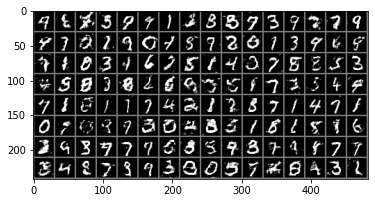

[Epoch 29/30] [Batch 429/468] [D loss: 0.011145] [G loss: 0.383960]
[Epoch 29/30] [Batch 430/468] [D loss: 0.014580] [G loss: 0.383960]
[Epoch 29/30] [Batch 431/468] [D loss: 0.011329] [G loss: 0.383960]
[Epoch 29/30] [Batch 432/468] [D loss: 0.013084] [G loss: 0.383960]
[Epoch 29/30] [Batch 433/468] [D loss: 0.013255] [G loss: 0.383960]
[Epoch 29/30] [Batch 434/468] [D loss: 0.020484] [G loss: 0.383960]
[Epoch 29/30] [Batch 435/468] [D loss: 0.011464] [G loss: 0.383960]
[Epoch 29/30] [Batch 436/468] [D loss: 0.011999] [G loss: 0.383960]
[Epoch 29/30] [Batch 437/468] [D loss: 0.013525] [G loss: 0.383960]
[Epoch 29/30] [Batch 438/468] [D loss: 0.012799] [G loss: 0.383960]
[Epoch 29/30] [Batch 439/468] [D loss: 0.011090] [G loss: 0.383960]
[Epoch 29/30] [Batch 440/468] [D loss: 0.011155] [G loss: 0.383960]
[Epoch 29/30] [Batch 441/468] [D loss: 0.013488] [G loss: 0.383960]
[Epoch 29/30] [Batch 442/468] [D loss: 0.011547] [G loss: 0.383960]
[Epoch 29/30] [Batch 443/468] [D loss: 0.009996]

In [15]:
# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
 
        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------
        if epoch%3 == 0 : 
              optimizer_G.zero_grad()

              # Sample noise as generator input
              z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

              # Generate a batch of images
              gen_imgs = generator(z)

              # Loss measures generator's ability to fool the discriminator
              g_loss = adversarial_loss(discriminator(gen_imgs), valid)

              g_loss.backward()
              optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        G_Loss.append(g_loss)
        D_Loss.append(d_loss)
        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
              # plt.figure()
              # plt.imshow(gen_imgs.data[:25].reshape(140, 140).cpu(), cmap='gray_r')
              # plt.show()
              
              def imshow(img,ax=None):
                  img = img / 2 + 0.5     # unnormalize
                  npimg = img.cpu().numpy()
                  if ax==None:
                    plt.imshow(np.transpose(npimg, (1, 2, 0)))
                    plt.show()
                  else:
                    ax.imshow(np.transpose(npimg, (1, 2, 0)))

              images = vutils.make_grid(gen_imgs, padding=2, normalize=False,nrow=16)
              imshow(images)
#             save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
      
      
        

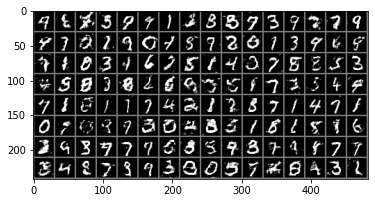

In [19]:
def imshow(img,ax=None):
                  img = img / 2 + 0.5     # unnormalize
                  npimg = img.cpu().numpy()
                  if ax==None:
                    plt.imshow(np.transpose(npimg, (1, 2, 0)))
                    plt.show()
                  else:
                    ax.imshow(np.transpose(npimg, (1, 2, 0)))

images = vutils.make_grid(gen_imgs, padding=2, normalize=False,nrow=16)
imshow(images)

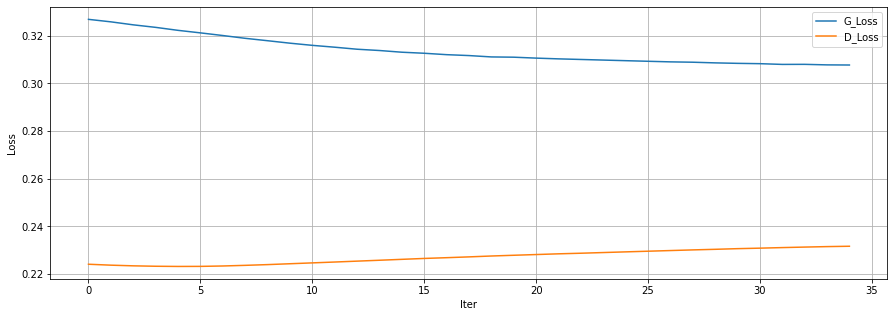

In [22]:
plt.figure(figsize=(15,5))

GG_Loss = []
DD_Loss = []

n = 0
for i in range(len(G_Loss)):
  if i%468 == 0 :
    GG_Loss.append(np.sum(G_Loss[n : n + 468])/468)
    DD_Loss.append(np.sum(D_Loss[n : n + 468])/468)
    n +=1

plt.plot(GG_Loss, label='G_Loss')
plt.plot(DD_Loss, label='D_Loss')
plt.legend()
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.grid()
plt.show()